In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np

# Custom Spatial Attention Layer
class SpatialAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv(concat)

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = layers.Dense(channel // ratio, activation='relu')(avg_pool)
    avg_pool = layers.Dense(channel, activation='sigmoid')(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = layers.Dense(channel // ratio, activation='relu')(max_pool)
    max_pool = layers.Dense(channel, activation='sigmoid')(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    spatial_attention = SpatialAttention()(channel_refined)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature

def create_cbam_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)  

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x) 

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x) 

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)  

    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)  


    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model



In [ ]:
(input_shape, num_classes) = ((64, 64, 3), 10)

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = tf.image.resize(x_train, (64, 64))
x_test = tf.image.resize(x_test, (64, 64))

model = create_cbam_model(input_shape=(64, 64, 3), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=64, epochs=50, validation_split=0.2)

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.1966 - loss: 2.1108 - val_accuracy: 0.4001 - val_loss: 1.6235
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4088 - loss: 1.5838 - val_accuracy: 0.5151 - val_loss: 1.3338
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5124 - loss: 1.3411 - val_accuracy: 0.5685 - val_loss: 1.1801
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5731 - loss: 1.1899 - val_accuracy: 0.6308 - val_loss: 1.0348
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6379 - loss: 1.0234 - val_accuracy: 0.6341 - val_loss: 1.0397
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6766 - loss: 0.9175 - val_accuracy: 0.6829 - val_loss: 0.9059
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7197 - loss: 0.8029 - val_accuracy: 0.6935 - val_loss: 0.8941
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━

In [3]:
model.save("attention.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


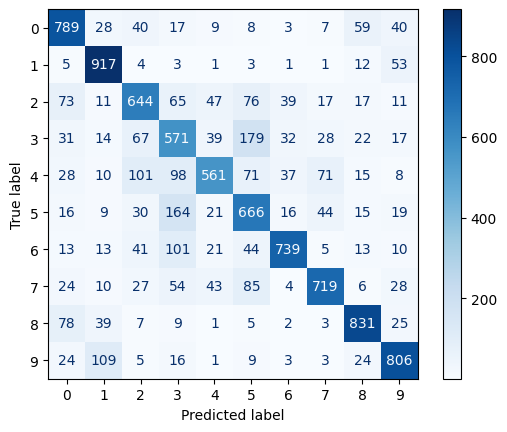

Confusion Matrix:
 [[789  28  40  17   9   8   3   7  59  40]
 [  5 917   4   3   1   3   1   1  12  53]
 [ 73  11 644  65  47  76  39  17  17  11]
 [ 31  14  67 571  39 179  32  28  22  17]
 [ 28  10 101  98 561  71  37  71  15   8]
 [ 16   9  30 164  21 666  16  44  15  19]
 [ 13  13  41 101  21  44 739   5  13  10]
 [ 24  10  27  54  43  85   4 719   6  28]
 [ 78  39   7   9   1   5   2   3 831  25]
 [ 24 109   5  16   1   9   3   3  24 806]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)  


true_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test  

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Confusion Matrix:\n", cm)



In [ ]:
x = model.layers[-4].output  
x = tf.keras.layers.Dense(512, activation='relu')(x)  
x = tf.keras.layers.Dense(3, activation='softmax')(x)  
new_model = tf.keras.Model(inputs=model.input, outputs=x)

for layer in model.layers[:-3]:
    layer.trainable = False

new_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 32)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            132 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 4)        │            132 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 32)       │            160 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1, 32)       │            160 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 32)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 32)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32, 32, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_attention         │ (None, 32, 32, 1)      │             99 │ multiply[0][0]         │
│ (SpatialAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32, 32, 32)     │              0 │ multiply[0][0],        │
│                           │                        │                │ spatial_attention[0][… │
├──────────────────────

 Total params: 2,796,522 (10.67 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 1,745,895 (6.66 MB)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_folder = '/content/drive/MyDrive/project_cs667/FD-MobileNet/dataset-resized/'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(dataset_folder, 'train')
test_dir = os.path.join(dataset_folder, 'valid')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  
    batch_size=32,  
    class_mode='categorical',  
    subset="training"  
)


val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  
    batch_size=32,  
    class_mode='categorical',  
    subset="validation"  
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 981 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 162 images belonging to 3 classes.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
print(train_generator.class_indices)

{'cardboard': 0, 'glass': 1, 'plastic': 2}


In [14]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
dummy_input = tf.random.normal([1, 64, 64, 3])  
new_model(dummy_input)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3352206 , 0.3254577 , 0.33932173]], dtype=float32)>

In [16]:
new_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step - accuracy: 0.5757 - loss: 0.9301 - val_accuracy: 0.5473 - val_loss: 0.9929
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - accuracy: 0.8081 - loss: 0.5200 - val_accuracy: 0.5432 - val_loss: 1.0201
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8835 - loss: 0.3631 - val_accuracy: 0.5844 - val_loss: 0.9902
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9554 - loss: 0.2218 - val_accuracy: 0.5679 - val_loss: 1.0299
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9695 - loss: 0.1587 - val_accuracy: 0.5679 - val_loss: 1.1255
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9779 - loss: 0.1128 - val_accuracy: 0.6049 - val_loss: 1.1170
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9954 - loss: 0.0734 - val_accuracy: 0.5885 - val_loss: 1.2016
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9943 - loss: 0.0537 - val_accuracy: 0.5638 - val_

In [17]:
test_loss, test_accuracy = new_model.evaluate(test_generator)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6562 - loss: 1.1160

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.7072 - loss: 0.9780
Test loss: 0.9220747947692871, Test accuracy: 0.7345678806304932


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step


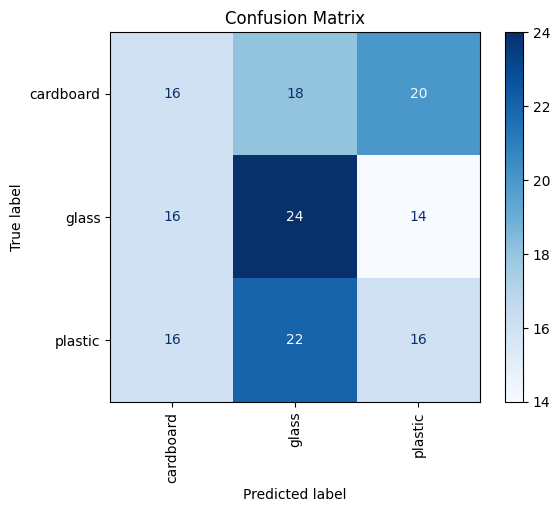

Confusion Matrix:
 [[16 18 20]
 [16 24 14]
 [16 22 16]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = new_model.predict(test_generator)  
predicted_classes = np.argmax(predictions, axis=1)  

# true labels
true_classes = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  


assert len(predicted_classes) == len(true_classes), "Mismatch in the number of predictions and true labels."


cm = confusion_matrix(true_classes, predicted_classes, labels=np.arange(len(class_labels)))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", cm)


In [23]:
new_model.save("attention_transfer.h5")

In [ ]:
x = model.layers[-3].output  
x = tf.keras.layers.Dense(512, activation='relu')(x)  # New dense layer
x = tf.keras.layers.Dense(3, activation='softmax')(x) 

fine_tuned_model = tf.keras.Model(inputs=model.input, outputs=x)
for layer in model.layers:
    if isinstance(layer, SpatialAttention):
        layer.trainable = False


# for layer in fine_tuned_model.layers[:-60]:
    # print(layer)
    # layer.trainable = False
fine_tuned_model.summary()
len(fine_tuned_model.layers)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 32)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 32)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            132 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 4)        │            132 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 32)       │            160 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1, 32)       │            160 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 32)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 32)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 32, 32, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_attention         │ (None, 32, 32, 1)      │             99 │ multiply[0][0]         │
│ (SpatialAttention)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32, 32, 32)     │              0 │ multiply[0][0],        │
│                           │                        │                │ spatial_attention[0][… │
├──────────────────────

 Total params: 3,059,178 (11.67 MB)

 Trainable params: 1,313,283 (5.01 MB)

 Non-trainable params: 1,745,895 (6.66 MB)

80

In [25]:
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
dummy_input = tf.random.normal([1, 64, 64, 3])  # Example input size for MobileNet
fine_tuned_model(dummy_input)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.37840402, 0.35524124, 0.26635474]], dtype=float32)>

In [27]:
fine_tuned_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.5425 - loss: 0.9232 - val_accuracy: 0.5103 - val_loss: 1.1336
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.7991 - loss: 0.5120 - val_accuracy: 0.5226 - val_loss: 1.1184
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9137 - loss: 0.3023 - val_accuracy: 0.5473 - val_loss: 1.2420
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9629 - loss: 0.1643 - val_accuracy: 0.5432 - val_loss: 1.2217
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9799 - loss: 0.0850 - val_accuracy: 0.5514 - val_loss: 1.3928
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9956 - loss: 0.0439 - val_accuracy: 0.5679 - val_loss: 1.5281
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9963 - loss: 0.0200 - val_accuracy: 0.5556 - val_loss: 1.6861
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9996 - loss: 0.0128 - val_accuracy:

In [28]:
test_loss, test_accuracy = fine_tuned_model.evaluate(test_generator)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.7029 - loss: 1.3844
Test loss: 1.290417194366455, Test accuracy: 0.709876537322998


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step


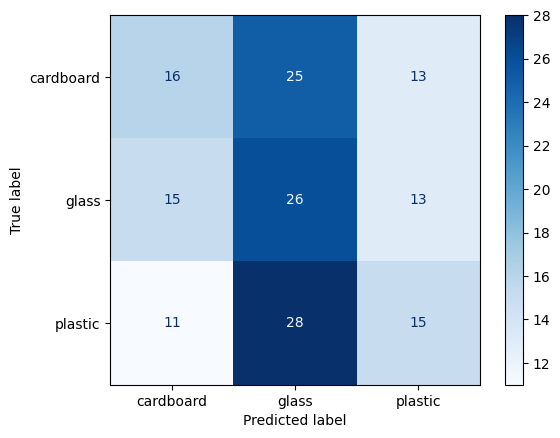

Confusion Matrix:
 [[16 25 13]
 [15 26 13]
 [11 28 15]]


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get predictions
predictions = fine_tuned_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Step 2: Extract true labels
true_classes = test_generator.classes  # Assuming test_generator has .classes attribute
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Step 3: Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Optional: Print confusion matrix
print("Confusion Matrix:\n", cm)


In [30]:
fine_tuned_model.save("attention_fintuned.h5")